In [ ]:
"""
02_data_cleaning.ipynb

This notebook handles the following tasks:
- Loads the dataset and inspects it
- Identifies and handles duplicate records
- Drops unnecessary columns
- Filters out invalid cases (e.g., sperm concentration < 2)
- Deals with missing values and imputes certain columns (KNN Imputation)
- Saves the cleaned dataset
"""

"\n02_data_cleaning.ipynb\n\nThis notebook handles the following tasks:\n- Loads the dataset and inspects it\n- Identifies and handles duplicate records\n- Drops unnecessary columns\n- Filters out invalid cases (e.g., sperm concentration < 2)\n- Deals with missing values and imputes certain columns (KNN Imputation)\n- Saves the cleaned dataset\n\nKey steps:\n- Remove duplicates from 'Case Number' column\n- Drop columns that are not needed\n- Filter out patients based on sperm concentration\n- Handle missing data via KNN imputation\n"

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

In [ ]:
# ==============================
# 1. Load and Inspect Raw Data
# ==============================

In [ ]:
data = pd.read_pickle('02_train_val_data.pkl')
test_data = pd.read_pickle('02_hold_out_test_data.pkl')

In [ ]:
original_shape = data.shape
original_shape_test = test_data.shape

In [ ]:
# ==============================
# 2. Handle Duplicates
# ==============================

In [ ]:
# Check for duplicates in the 'Case Number' column
duplicates = data['Case Number'].duplicated().sum()
duplicates_test = test_data['Case Number'].duplicated().sum()

print(f"Number of duplicate case numbers: {duplicates}")
print(f"Number of duplicate case numbers: {duplicates_test}")

Number of duplicate case numbers: 0
Number of duplicate case numbers: 0


In [ ]:
# ==============================
# 3. Remove Unnecessary Columns
# ==============================

In [ ]:
# saved for potential visualization
patient_ID = data.drop(columns=['Case Number'])
patient_ID_test = test_data.drop(columns=['Case Number'])

# Remove unnecessary columns
cleaned_data = data.drop(columns=['Case Number'])
cleaned_test_data = test_data.drop(columns=['Case Number'])

In [ ]:
# ==============================
# 4. Filter Invalid Cases (e.g., sperm concentration < 2)
# ==============================

In [ ]:
# Remove patients with sperm concentration below 2
cleaned_data = cleaned_data[cleaned_data['Sperm Concentration'] >= 2]

In [ ]:
# ==============================
# 5. Handle Missing Values
# ==============================

In [ ]:
# Check for missing values
cleaned_data.isnull().sum()

,0
Semen Volume,0
DFI,170
TUNEL,37
Sperm Concentration,0
Total Motility,0
Progressive Motility,0
Non-progressive Motility,0
Immotile Sperm,0
Abnormal Morphology,26
Age,262


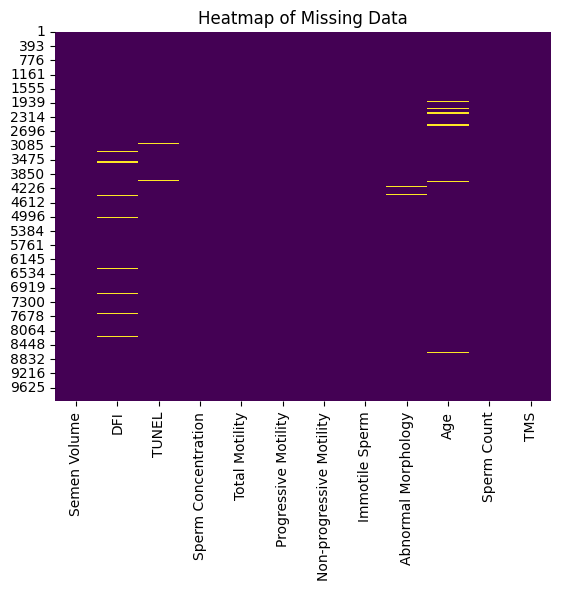

In [ ]:
# Visualize missing data
sns.heatmap(cleaned_data.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data')
plt.show()

In [ ]:
# Drop rows with missing 'DFI' or 'TUNEL'
cleaned_data.dropna(subset=['DFI'], inplace=True)
cleaned_data.dropna(subset=['TUNEL'], inplace=True)

# Verify no missing values after drop
print("Missing values after cleaning:")
print(cleaned_data.isnull().sum())

Missing values after cleaning:
Semen Volume                  0
DFI                           0
TUNEL                         0
Sperm Concentration           0
Total Motility                0
Progressive Motility          0
Non-progressive Motility      0
Immotile Sperm                0
Abnormal Morphology          26
Age                         255
Sperm Count                   0
TMS                           0
dtype: int64


In [ ]:
def knn_impute(data, columns_to_impute):
    # Separate numerical and categorical columns
    numeric_columns = data.select_dtypes(include=['number']).columns.tolist()
    categorical_columns = data.select_dtypes(exclude=['number']).columns.tolist()

    # Keep track of the original indices
    original_indices = data.index

    # Split the data into numerical and categorical parts
    data_numeric = data[numeric_columns]
    data_categorical = data[categorical_columns]

    # Apply scaling only to the columns that need imputation
    features_to_scale = [col for col in columns_to_impute if col in numeric_columns]
    scaler = MinMaxScaler()
    data_numeric_scaled = data_numeric.copy()

    # Scale only the columns that need imputation
    if features_to_scale:
        data_numeric_scaled[features_to_scale] = scaler.fit_transform(data_numeric[features_to_scale])

    # Apply KNN imputation only to the imputation columns
    imputer = KNNImputer(n_neighbors=5)
    data_numeric_imputed = data_numeric.copy()
    data_numeric_imputed[columns_to_impute] = imputer.fit_transform(data_numeric_scaled[columns_to_impute])

    # Revert scaling back to the original values only for imputed columns
    if features_to_scale:
        data_numeric_imputed[features_to_scale] = scaler.inverse_transform(data_numeric_imputed[features_to_scale])

    # Concatenate with categorical columns
    data_imputed = pd.concat([data_numeric_imputed, data_categorical], axis=1)

    # Ensure indices are preserved
    data_imputed.index = original_indices

    # Round numerical columns to 1 decimal point for consistency (only for imputed columns)
    for col in columns_to_impute:
        if col in data_imputed.columns:
            data_imputed[col] = data_imputed[col].round(1)

    return data_imputed

In [ ]:
# Impute missing 'Abnormal Morphology' and 'Age'
imputed_data = knn_impute(cleaned_data,['Abnormal Morphology', 'Age'])

In [ ]:
# ==============================
# 7. Final Check and Save Cleaned Data
# ==============================

In [ ]:
# Final check for missing values
print(imputed_data.isnull().sum())

Semen Volume                0
DFI                         0
TUNEL                       0
Sperm Concentration         0
Total Motility              0
Progressive Motility        0
Non-progressive Motility    0
Immotile Sperm              0
Abnormal Morphology         0
Age                         0
Sperm Count                 0
TMS                         0
dtype: int64


In [ ]:
# Compare shape before and after cleaning
cleaned_shape = imputed_data.shape
print(f"✅ Original data size: {original_shape}")
print(f"✅ Test data size: {original_shape_test}")
print(f"✅ Cleaned data size: {cleaned_shape}")
print(f"✅ Cleaned Test data size: {cleaned_test_data.shape}")
print(f"✅ Number of missing patinets after imputation: {data.isnull().sum().sum()}")
print(f"✅ Percentage of losing data: {round((original_shape[0]-cleaned_shape[0])*100/original_shape[0],2)}%")

# Save the cleaned dataset
imputed_data.to_pickle('03_cleaned_data.pkl')
cleaned_test_data.to_pickle('03_cleaned_test_data.pkl')

✅ Original data size: (9003, 13)
✅ Test data size: (1000, 13)
✅ Cleaned data size: (8716, 12)
✅ Cleaned Test data size: (1000, 12)
✅ Number of missing patinets after imputation: 569
✅ Percentage of losing data: 3.19%
